# 분석을 위한 데이터 핸들링 하기

빠른 분석을 위해 몇가지 조건으로 데이터를 처리하겠습니다. 
- 칼럼 이름을 한글로 변경
- 이주일치만 남기기 - 빠른 분석을 위함
- A03에서 구매한 사람의 데이터만 구성
- 한번도 구매 안한사람 제외 
- 아이템을 영어에서 한글로 바꿈
- 간단한 전처리

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import warnings
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tq
pd.set_option('display.max_row',300)
%matplotlib inline
warnings.filterwarnings(action='ignore')

## load data

In [26]:
cks_dtype = {'clnt_id':'int64','sess_id':'int64','hit_seq':'int64','action_type':'int64','biz_unit':'category','sess_dt':'object','hit_tm':'object',
             'hit_pss_tm':'int64','trans_id':'float64','sech_kwd':'object','tot_pag_view_ct':'float64','tot_sess_hr_v':'float64','trfc_src':'category',
             'dvc_ctg_nm':'object','pd_c':'object','de_dt':'object','de_tm':'object','buy_am':'int64','buy_ct':'int64','clnt_gender':'category'}

online = pd.read_csv('./DATA/온라인 행동 정보(CKS).csv', dtype=cks_dtype)
trade = pd.read_csv('./DATA/거래 정보(CKS).csv', dtype=cks_dtype)
customer = pd.read_csv('./DATA/고객 정보(CKS).csv', dtype=cks_dtype)
item = pd.read_csv('./DATA/item_add_nm0.csv', dtype=cks_dtype)

In [27]:
online.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app


In [4]:
df1_online = online.copy()

<br>

### 변수 생성: `weekday`, `holiday`
- 날짜 데이터를 활용하여 `weekday` 요일을 생성하겠습니다. 
- (예) 요일숫자(0-월, 1-화, 2-수, ....)
<br>

- 주말, 광복절, 추석은 `holiday`로 생성합니다. 
- (예) '2019-08-15'-광복절, '2019-09-12'-추석연휴,'2019-09-13'-추석연휴
    - 주말과 공휴일은 1, 그 외 요일은 0이 됩니다. 
    - hit_seq 1\~4에는 buy_id가 1, hit_seq 5\~10에 buy_id가 2가 됩니다.

In [51]:
holist = ['2019-08-15','2019-09-12','2019-09-13'] # 공휴일 list

df1_online.sess_dt = pd.to_datetime(df1_online.sess_dt, format='%Y%m%d') # sess_dt col의 자료형 변경
df1_online['day'] = df1_online['sess_dt'].dt.weekday #요일숫자(0-월, 1-화) (=dayofweek)
df1_online['holiday'] = df1_online['day'].apply(lambda x: (x==5)|(x==6)).astype(np.int64)
df1_online['holiday'] = df1_online['holiday'] + df1_online['sess_dt'].apply(lambda x: x.strftime('%Y-%m-%d') in holist)
df1_online.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,hour,day,holiday
0,1,1,1,0,A01,2019-09-11,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app,16,2,0
1,1,1,2,0,A01,2019-09-11,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,16,2,0
2,1,1,3,0,A01,2019-09-11,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app,16,2,0
3,1,2,1,0,A01,2019-09-22,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app,14,6,1
4,1,2,2,0,A01,2019-09-22,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app,14,6,1


<br>

### 변수 생성: `hour`
- `hit_tm`을 시간대별 분류를 통해 카테고리화하였습니다.
- (예) 23:35 -> 23, 23:47 -> 23

In [5]:
df1_online['hour'] = df1_online['hit_tm'].apply(lambda x: np.int8(x[:2]))
df1_online.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,hour
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app,16
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,16
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app,16
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app,14
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app,14


<br>

### 변수 생성: `latest`
- 고객의 과거 행동을 담은 변수입니다. 
    - `latest_kwd_1`~`latest_kwd_6`: 가장 최근 검색한 여섯 개의 키워드를 담은 변수입니다.
    - `latest_pv_hr`
        - `pv_hr`은 온라인행동데이터의 `세션내총페이지뷰수/세션내총시간`으로 단위 페이지당 머무른 시간을 나타내는 서핑속도입니다.
        - `latest_pv_hr_1` \~ `latest_pv_hr_3`: 최근 쇼핑의 3개의 페이지 서핑 속도를 반영합니다.

<br>

### 변수 생성 : `dvc_ctg_nm`
- 고객이 주로 사용하는 기기를 담은 변수입니다. 
- 상품 
- (예) 

In [57]:
df1_online.loc[df1_online['dvc_ctg_nm']=='unknown', 'dvc_ctg_nm'] = 'mobile_app'

In [67]:
test = df1_online.groupby('clnt_id')['dvc_ctg_nm'].apply(lambda x: ', '.join(set(x)))

In [69]:
test.value_counts()

mobile_web                38626
mobile_app                20994
PC                        12630
mobile_web, PC              111
mobile_app, mobile_web       24
mobile_app, PC               14
Name: dvc_ctg_nm, dtype: int64

<br>

### 변수 생성: `trfc_src`
- 고객이 어떤 유입 채널을 선호하는가?
- 상품 
- (예) clnt_id, sess_id 가 모두 1인 고객의 hit_seq가 10까지 있는 경우
    - hit_seq가 4, 10에 구매가 발생했을 경우,
    - hit_seq 1\~4에는 buy_id가 1, hit_seq 5\~10에 buy_id가 2가 됩니다.

In [70]:
test = df1_online.groupby('clnt_id')['trfc_src'].apply(lambda x: ', '.join(set(x)))

In [71]:
test.value_counts()

unknown                                          44171
DIRECT                                           13582
PORTAL_1                                          3345
PUSH, DIRECT                                      2800
PUSH                                              2687
WEBSITE                                           1093
WEBSITE, DIRECT                                    993
PORTAL_2                                           464
PORTAL_3                                           424
WEBSITE, PUSH                                      378
unknown, PORTAL_1                                  361
PORTAL_1, unknown                                  361
WEBSITE, PORTAL_1                                  313
WEBSITE, PUSH, DIRECT                              262
PORTAL_3, unknown                                  217
PORTAL_1, DIRECT                                   185
DIRECT, PORTAL_1                                    84
PORTAL_2, DIRECT                                    78
PORTAL_1, 

<br>

### 외부데이터: `날짜별 온도`, ``, ``
- merge를 하기 전 trans_id의 중복을 제거하기 위함입니다. 
- 습도, 기온, 강수형태, 강수량

In [30]:
HUM = pd.read_csv('./data/습도_201907_201909.csv')
TEMP = pd.read_csv('./data/기온_201907_201909.csv')
PTY = pd.read_csv('./data/강수형태_201907_201909.csv')
R06 = pd.read_csv('./data/강수량_201907_201909.csv')

비구매 고객이든 구매고객이든 향후 어떤 제품을 선호할지 예측하고 추천하는 시스템. 
비구매 고객 -> Trade 데이터에 있는 feature 값들이 Nan으로. 


<br>

### 데이터 처리: `Trade + Item`
- 거래 ID와 Item을 `pd_c` 기준으로 합쳐줍니다. 


In [ ]:
# 거래정보(trans_id)를 적어도 하나 가지고있는(결측값이 아닌) 세션만을 가져오기 위한 사용자정의함수입니다.
def det_(df):
    nrows = df.shape[0]
    if df['trans_id'].isnull().value_counts().iloc[0] != nrows:
        return df

In [ ]:
# trans_id 가 있는 세션만 가져옴
df1_transO = df1_known.groupby(['clnt_id', 'sess_id']).apply(lambda x : det_(x))
df1_transO.reset_index(drop = True, inplace = True)
df1_transO.head()

In [ ]:
df2_df4 = df2trade.merge(df4item, how = 'left')
df2_df4.head()

<br>

### 데이터 처리: `Online + Trade`
- merge를 하기 전 trans_id의 중복을 제거하기 위함입니다. 


In [7]:
trans_list = list(online[~online['trans_id'].isnull()]['trans_id'].unique())
idx_list = [online.index[0]]
for i in trans_list:
    idx_list.append(online[online['trans_id'] == i].index.max())

In [9]:
online.loc[idx_list]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app
46,2,1,37,6,A03,20190728,23:47,791905,62037.0,NaN,61.0,911.0,DIRECT,unknown
145,2,8,68,6,A03,20190731,21:25,3251794,64691.0,NaN,85.0,3256.0,DIRECT,unknown
167,2,10,16,6,A03,20190801,22:00,306944,65505.0,NaN,23.0,353.0,DIRECT,unknown
247,2,19,17,6,A03,20190830,22:00,2227390,88495.0,NaN,29.0,2253.0,DIRECT,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196182,72418,3,12,6,A02,20190919,12:52,2359650,104648.0,NaN,22.0,2360.0,unknown,PC
3196189,72419,1,5,6,A02,20190902,21:19,743203,90888.0,NaN,39.0,743.0,unknown,mobile_web
3196201,72423,1,1,6,A01,20190917,11:48,116283,102596.0,NaN,24.0,114.0,unknown,mobile_app
3196293,72424,2,52,6,A03,20190924,17:12,2410463,108506.0,NaN,82.0,2445.0,PORTAL_1,PC


In [53]:
online.loc[idx_list]['trans_id'].value_counts()

39950.0     1
70687.0     1
104016.0    1
60237.0     1
91095.0     1
           ..
38786.0     1
60553.0     1
63074.0     1
99132.0     1
81920.0     1
Name: trans_id, Length: 50997, dtype: int64

In [34]:
trade['trans_id'].value_counts()[104537.0]

1

In [48]:
trade

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
0,2,42449.0,1,A02,1015.0,20190704,15:34,46430,1
1,2,62037.0,1,A03,92.0,20190729,23:47,36000,20
2,2,64691.0,1,A03,186.0,20190731,21:25,3790,1
3,2,64691.0,2,A03,151.0,20190731,21:25,3990,1
4,2,64691.0,3,A03,351.0,20190731,21:25,4690,1
...,...,...,...,...,...,...,...,...,...
599956,72424,136596.0,38,B01,1580.0,20190727,11:22,2500,1
599957,72424,136596.0,39,B01,391.0,20190727,11:22,12980,1
599958,72424,136596.0,40,B01,964.0,20190727,11:22,2980,1
599959,72424,136596.0,41,B01,1571.0,20190727,11:22,1380,1


In [46]:
trade[trade['biz_unit'].apply(lambda x: x.startswith('A'))]['trans_id'].value_counts()

51589.0     100
102723.0     72
39972.0      44
91173.0      42
42701.0      42
           ... 
105276.0      1
47611.0       1
66596.0       1
60066.0       1
65536.0       1
Name: trans_id, Length: 44937, dtype: int64

In [3]:
temp = pd.merge(online, 
                trade[['trans_id', 'pd_c']], 
                on='trans_id', how='left')

df_merge = pd.merge(temp[(temp['pd_c'].notnull())], 
                    item[['pd_c', 'clac_nm0']], 
                    on='pd_c')

In [7]:
A_1 = pd.DataFrame(data=[[1, 2, 3], 
                   [4, 5, 6], 
                   [7, 8, 9]], 
             columns=['A', 'B', 'C'])

In [16]:
A_2 = pd.DataFrame(data=[[4, 2, 3], 
                   [3, 5, 4], 
                   [7, 3, 4],
                   [7, 8, 7]], 
             columns=['E', 'F', 'A'])

In [20]:
A_1

,A,B,C
0,1,2,3
1,4,5,6
2,7,8,9


In [19]:
A_2

,E,F,A
0,4,2,3
1,3,5,4
2,7,3,4
3,7,8,7


In [17]:
pd.merge(A_1, A_2, on='A')

,A,B,C,E,F
0,4,5,6,3,5
1,4,5,6,7,3
2,7,8,9,7,8


In [18]:
pd.merge(A_1, A_2, on='A', how='left')

,A,B,C,E,F
0,1,2,3,NaN,NaN
1,4,5,6,3.0,5.0
2,4,5,6,7.0,3.0
3,7,8,9,7.0,8.0


In [21]:
pd.merge(A_2, A_1, on='A', how='left')

,E,F,A,B,C
0,4,2,3,NaN,NaN
1,3,5,4,5.0,6.0
2,7,3,4,5.0,6.0
3,7,8,7,8.0,9.0


In [30]:
item['clac_nm0'].value_counts()

Food              637
Kitchen / Life    240
Fashion           198
Sport             177
Baby              126
Electronic         86
Beauty             86
Furniture          86
Travel             28
Others              3
Name: clac_nm0, dtype: int64

In [27]:
orders = ['Food', 'Kitchen / Life', 'Fashion', 'Sport', 'Baby', 'Electronic',
       'Beauty', 'Furniture', 'Travel', 'Others']

In [34]:
np.log(df_merge[df_merge['biz_unit']=='A03']['clac_nm0'].value_counts())

Food              11.574970
Kitchen / Life     8.307706
Beauty             7.310550
Baby               5.347108
Furniture          4.290459
Sport              3.806662
Electronic         3.784190
Fashion            0.000000
Name: clac_nm0, dtype: float64

TypeError: loop of ufunc does not support argument 0 of type str which has no callable log method

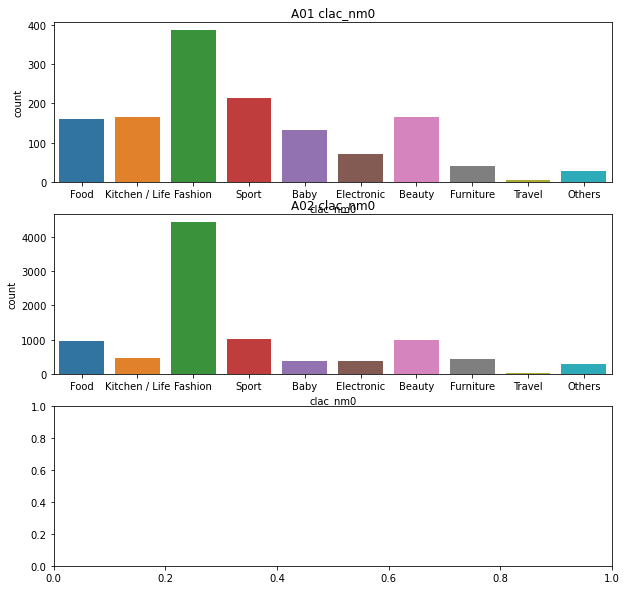

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))

sns.countplot(df_merge[df_merge['biz_unit']=='A01']['clac_nm0'], order=orders,ax=axs[0]).set_title('A01 clac_nm0')
sns.countplot(df_merge[df_merge['biz_unit']=='A02']['clac_nm0'], order=orders, ax=axs[1]).set_title('A02 clac_nm0')
sns.countplot(df_merge[df_merge['biz_unit']=='A03']['clac_nm0'], order=orders, ax=axs[2]).set_title('A03 clac_nm0')

In [11]:
np.log10(df_merge[df_merge['biz_unit']=='A03']['clac_nm0'].value_counts())

Food              5.026946
Kitchen / Life    3.607991
Beauty            3.174932
Baby              2.322219
Furniture         1.863323
Sport             1.653213
Electronic        1.643453
Fashion           0.000000
Name: clac_nm0, dtype: float64

In [8]:
df_merge[df_merge['biz_unit']=='A01']['clac_nm0'].value_counts()

Fashion           387
Sport             214
Beauty            166
Kitchen / Life    166
Food              161
Baby              133
Electronic         72
Furniture          42
Others             27
Travel              6
Name: clac_nm0, dtype: int64

### 2개월치만 가져옴

In [148]:
df_merge.sort_values(by='sess_dt', inplace=True)
df_merge1 = df_merge[df_merge['sess_dt'] < '20190831']

### 구매 이력이 130 이상인 고객만 가져옴

In [164]:
trans_index = df_merge1['clnt_id'].value_counts()[df_merge1['clnt_id'].value_counts() > 130].index

In [165]:
df_merge2 = df_merge1[df_merge1['clnt_id'].apply(lambda x: x in trans_index)]

In [166]:
df_merge2

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,pd_c,clac_nm0
111494,22910,1,74,6,A03,20190701,01:00,1345382,38876.0,NaN,76.0,1364.0,DIRECT,unknown,862.0,Kitchen / Life
102024,22910,1,74,6,A03,20190701,01:00,1345382,38876.0,NaN,76.0,1364.0,DIRECT,unknown,181.0,Food
14166,30018,1,18,6,A03,20190701,13:20,326951,39020.0,NaN,19.0,327.0,DIRECT,unknown,347.0,Food
39863,22910,1,74,6,A03,20190701,01:00,1345382,38876.0,NaN,76.0,1364.0,DIRECT,unknown,353.0,Food
112592,49028,3,33,6,A03,20190701,23:57,926206,39245.0,NaN,40.0,1024.0,DIRECT,unknown,1197.0,Food
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44210,22910,41,29,6,A03,20190830,23:20,651367,88516.0,NaN,30.0,651.0,DIRECT,unknown,1213.0,Food
58970,30018,16,60,6,A03,20190830,13:47,1337493,88364.0,NaN,57.0,1337.0,DIRECT,unknown,1385.0,Food
14996,49906,203,98,6,A03,20190830,23:57,2737049,88527.0,NaN,102.0,2780.0,DIRECT,unknown,347.0,Food
76315,30018,16,60,6,A03,20190830,13:47,1337493,88364.0,NaN,57.0,1337.0,DIRECT,unknown,542.0,Food


In [167]:
df_merge2['clnt_id'].value_counts()

68849    167
49028    154
57558    153
15315    151
30018    148
63332    143
17390    142
62256    140
22910    139
31100    136
49906    135
72007    135
Name: clnt_id, dtype: int64

In [168]:
df_merge2[df_merge2['clnt_id']==68849]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,pd_c,clac_nm0
119834,68849,2,42,6,A03,20190704,13:49,4908685,41822.0,NaN,91.0,4921.0,DIRECT,mobile_web,1157.0,Food
36277,68849,2,42,6,A03,20190704,13:49,4908685,41822.0,NaN,91.0,4921.0,DIRECT,mobile_web,183.0,Food
112047,68849,2,42,6,A03,20190704,13:49,4908685,41822.0,NaN,91.0,4921.0,DIRECT,mobile_web,1224.0,Food
101524,68849,2,42,6,A03,20190704,13:49,4908685,41822.0,NaN,91.0,4921.0,DIRECT,mobile_web,1588.0,Food
89470,68849,2,42,6,A03,20190704,13:49,4908685,41822.0,NaN,91.0,4921.0,DIRECT,mobile_web,1584.0,Food
37267,68849,2,42,6,A03,20190704,13:49,4908685,41822.0,NaN,91.0,4921.0,DIRECT,mobile_web,943.0,Food
121457,68849,2,42,6,A03,20190704,13:49,4908685,41822.0,NaN,91.0,4921.0,DIRECT,mobile_web,403.0,Food
120523,68849,2,42,6,A03,20190704,13:49,4908685,41822.0,NaN,91.0,4921.0,DIRECT,mobile_web,1590.0,Food
98435,68849,2,42,6,A03,20190704,13:49,4908685,41822.0,NaN,91.0,4921.0,DIRECT,mobile_web,1583.0,Food
79900,68849,2,42,6,A03,20190704,13:49,4908685,41822.0,NaN,91.0,4921.0,DIRECT,mobile_web,519.0,Food


In [169]:
df_merge2[df_merge2['clnt_id']==49028]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,pd_c,clac_nm0
112592,49028,3,33,6,A03,20190701,23:57,926206,39245.0,NaN,40.0,1024.0,DIRECT,unknown,1197.0,Food
41449,49028,3,33,6,A03,20190701,23:57,926206,39245.0,NaN,40.0,1024.0,DIRECT,unknown,354.0,Food
112593,49028,3,33,6,A03,20190701,23:57,926206,39245.0,NaN,40.0,1024.0,DIRECT,unknown,1197.0,Food
76594,49028,3,33,6,A03,20190701,23:57,926206,39245.0,NaN,40.0,1024.0,DIRECT,unknown,542.0,Food
96193,49028,3,33,6,A03,20190701,23:57,926206,39245.0,NaN,40.0,1024.0,DIRECT,unknown,1198.0,Food
57552,49028,3,33,6,A03,20190701,23:57,926206,39245.0,NaN,40.0,1024.0,DIRECT,unknown,565.0,Food
14946,49028,3,33,6,A03,20190701,23:57,926206,39245.0,NaN,40.0,1024.0,DIRECT,unknown,347.0,Food
18002,49028,3,33,6,A03,20190701,23:57,926206,39245.0,NaN,40.0,1024.0,DIRECT,unknown,188.0,Food
90959,49028,10,25,6,A03,20190708,19:44,1792124,45456.0,NaN,32.0,1816.0,DIRECT,unknown,107.0,Food
14947,49028,10,25,6,A03,20190708,19:44,1792124,45456.0,NaN,32.0,1816.0,DIRECT,unknown,347.0,Food


In [170]:
df_merge2[df_merge2['clnt_id']==57558]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,pd_c,clac_nm0
60231,57558,7,18,6,A03,20190702,13:09,563273,40048.0,NaN,16.0,575.0,DIRECT,unknown,1202.0,Food
100490,57558,7,18,6,A03,20190702,13:09,563273,40048.0,NaN,16.0,575.0,DIRECT,unknown,352.0,Food
53527,57558,7,18,6,A03,20190702,13:09,563273,40048.0,NaN,16.0,575.0,DIRECT,unknown,178.0,Food
53526,57558,7,18,6,A03,20190702,13:09,563273,40048.0,NaN,16.0,575.0,DIRECT,unknown,178.0,Food
112231,57558,7,18,6,A03,20190702,13:09,563273,40048.0,NaN,16.0,575.0,DIRECT,unknown,558.0,Food
53528,57558,7,18,6,A03,20190702,13:09,563273,40048.0,NaN,16.0,575.0,DIRECT,unknown,178.0,Food
78673,57558,7,18,6,A03,20190702,13:09,563273,40048.0,NaN,16.0,575.0,DIRECT,unknown,1123.0,Food
41729,57558,7,18,6,A03,20190702,13:09,563273,40048.0,NaN,16.0,575.0,DIRECT,unknown,354.0,Food
78206,57558,7,18,6,A03,20190702,13:09,563273,40048.0,NaN,16.0,575.0,DIRECT,unknown,1393.0,Food
82521,57558,7,18,6,A03,20190702,13:09,563273,40048.0,NaN,16.0,575.0,DIRECT,unknown,521.0,Food


In [157]:
df_merge2[df_merge2['clnt_id']==56072]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,pd_c,clac_nm0
41671,56072,2,1,6,A03,20190702,20:01,1897,39951.0,NaN,1.0,2.0,PUSH,mobile_web,354.0,Food
41670,56072,1,6,6,A03,20190702,11:02,316626,39951.0,NaN,10.0,317.0,PUSH,mobile_web,354.0,Food
16852,56072,2,1,6,A03,20190702,20:01,1897,39951.0,NaN,1.0,2.0,PUSH,mobile_web,350.0,Food
16851,56072,1,6,6,A03,20190702,11:02,316626,39951.0,NaN,10.0,317.0,PUSH,mobile_web,350.0,Food
28579,56072,1,6,6,A03,20190702,11:02,316626,39951.0,NaN,10.0,317.0,PUSH,mobile_web,964.0,Food
28580,56072,2,1,6,A03,20190702,20:01,1897,39951.0,NaN,1.0,2.0,PUSH,mobile_web,964.0,Food
45538,56072,1,6,6,A03,20190702,11:02,316626,39951.0,NaN,10.0,317.0,PUSH,mobile_web,1213.0,Food
80341,56072,2,1,6,A03,20190702,20:01,1897,39951.0,NaN,1.0,2.0,PUSH,mobile_web,1189.0,Food
80340,56072,1,6,6,A03,20190702,11:02,316626,39951.0,NaN,10.0,317.0,PUSH,mobile_web,1189.0,Food
45539,56072,1,6,6,A03,20190702,11:02,316626,39951.0,NaN,10.0,317.0,PUSH,mobile_web,1213.0,Food


In [23]:
item

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,1.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,2.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,3.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,4.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,5.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades
...,...,...,...,...
1662,1663.0,Women's Clothing,Women's Upper Bodywear / Tops,Women's Cardigans
1663,1664.0,Women's Clothing,Women's Upper Bodywear / Tops,Women's Sweaters / Pullover
1664,1665.0,Women's Clothing,Women's Upper Bodywear / Tops,Women's Sweatshirts / Hoodies
1665,1666.0,Women's Clothing,Women's Upper Bodywear / Tops,Women's T-shirts / Tops


In [24]:
trade['pd_c'].value_counts()

1213.0    15518
347.0     12914
964.0     11115
1395.0    11083
1617.0    10850
          ...  
149.0         1
1631.0        1
597.0         1
598.0         1
1432.0        1
Name: pd_c, Length: 1667, dtype: int64

In [6]:
test = pd.merge(online,trade)

In [ ]:
model(사람 A) = 추천 아이템 pred

In [ ]:
model(사람 A, 그 시점에서 과거 데이터) = 추천 아이템 pred

In [12]:
online.columns

Index(['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'biz_unit', 'sess_dt',
       'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd', 'tot_pag_view_ct',
       'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm'],
      dtype='object')

In [ ]:
[ 'action_type', 'biz_unit', 'sess_dt',
       'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd', 'tot_pag_view_ct',
       'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm', 'age', 'gender']

In [ ]:
Targe = ['소분류']

In [ ]:
온라인 데이터에서 구매하지않은 고객 + 구매한 고객

In [ ]:
[ 'action_type', 'biz_unit', 'sess_dt',
       'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd', 'tot_pag_view_ct',
       'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm', 'trans_seq', 'pd_c', 'de_dt',
       'de_tm', 'buy_am', 'buy_ct']

In [ ]:
온라인 데이터에서 구매한 고객

In [ ]:
온라인 데이터에서 구매한 고객 Prediction 추천을 하는거

In [29]:
(trade['trans_id'].value_counts() > 10).sum()

15608

In [11]:
test.columns

Index(['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'biz_unit', 'sess_dt',
       'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd', 'tot_pag_view_ct',
       'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm', 'trans_seq', 'pd_c', 'de_dt',
       'de_tm', 'buy_am', 'buy_ct'],
      dtype='object')

In [8]:
test['clnt_id'].value_counts()

54703    229
49906    225
22910    222
30018    216
49028    214
        ... 
5798       1
26280      1
30978      1
59600      1
14343      1
Name: clnt_id, Length: 8869, dtype: int64

In [5]:
online.head(20)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app
5,1,2,3,0,A01,20190922,14:10,70025,NaN,초등남아옷,45.0,424.0,unknown,mobile_app
6,1,2,4,0,A01,20190922,14:11,119527,NaN,초등남아점퍼,45.0,424.0,unknown,mobile_app
7,1,2,5,0,A01,20190922,14:11,162327,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app
8,1,2,6,0,A01,20190922,14:12,178832,NaN,노스페이스초등,45.0,424.0,unknown,mobile_app
9,1,2,7,0,A01,20190922,14:12,192367,NaN,노스페이스키즈,45.0,424.0,unknown,mobile_app


In [8]:
test =online.copy()
test['action_type'] = test['action_type'].astype(str)

In [21]:
test1 = pd.DataFrame(test.groupby('clnt_id')['action_type'].apply(lambda x: ','.join(set(x))))

In [36]:
test1

,action_type
clnt_id,
1,0
2,"1,6,0,5,2,3,4"
3,0
4,"6,0"
5,3
...,...
72425,0
72426,"2,1,0"
72427,"1,6,0,5,2"


In [40]:
clnt_list = []
for i in test1['action_type'].index:
    if '6' in test1['action_type'][i].split(','):
        clnt_list.append(i)

In [42]:
len(clnt_list)

20833

In [ ]:
uniq_clnt = pd.DataFrame(raw_data1_Online_Act.groupby('clnt_id')['biz_unit'].apply(lambda x: ','.join(set(x))))
sns.countplot(uniq_clnt['biz_unit'])

In [17]:
online.shape

(3196362, 14)

In [18]:
customer.head()

,clnt_id,clnt_gender,clnt_age
0,1,NaN,NaN
1,2,F,30.0
2,3,NaN,NaN
3,4,NaN,NaN
4,5,NaN,NaN


In [19]:
item.head()

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,1.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,2.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,3.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,4.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,5.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades


### 데이터를 이주일치만 남기기

분석을 하다보면 많은 데이터의 양이 불필요한 시간낭비를 초래합니다.  
그래서 3개월이 아닌 2주만 남기고 데이터를 정리했습니다. 

In [8]:
online_week = online[online['sess_dt'] < 20190715]
online_week = online_week.sort_values(by='sess_dt')
online_week.shape

### A03을 제외한 row 제거

온라인 데이터에서는 총 3군데 (A01, A02, A03)의 biz_unit 정보가 있습니다.  
이 중에서 A03만 남기고 제외하겠습니다.

In [9]:
online_week = online_week[online_week['biz_unit'] == 'A03']

In [10]:
online_week.shape

(375281, 15)

### 영어에서 한글로 바꿈

sech_kwd는 한글로 되어있는 반면, pd_c 정보는 영어로 되어 있습니다.  
추후에 sech_kwd와 pd_c 정보의 상관 관계를 파악하기 위해서 한글로 변경하겠습니다. 

In [9]:
item.head()

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,1.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,2.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,3.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,4.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,5.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades


In [20]:
csv_path=os.getenv("HOME") + ('/repo/Hackathon/Lpoint Competition/csv/')
papago = pd.read_csv(csv_path+ 'papago.csv', header=None)
item['clac_nm3'] = papago[0]
item.head()

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,1.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,자동차 오일/첨가물
1,2.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,카 라이트
2,3.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,카 페인트
3,4.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,필터
4,5.0,Automotive Products,Automotive Replacement Repair / Maintanance Kits,와이퍼 블레이드


In [13]:
item['clac_nm3'][963] = '닭고기 달걀'
item['clac_nm3'] = item['clac_nm3'].fillna('nan')

In [14]:
item['clac_nm3'].isna().sum()

0

### 간단한 전처리

앞선 전처리 이외에도 처리가 안된 데이터를 정리해줍니다.

In [11]:
import matplotlib.font_manager as fm
%matplotlib inline
warnings.filterwarnings(action='ignore')
path = 'DATA/font/NanumGothic-ExtraBold.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [12]:
customer.loc[customer['clnt_gender']=='unknown','clnt_gender'] = np.NaN
customer['clnt_gender'] = customer['clnt_gender'].astype('category')

customer.loc[customer['clnt_age']=='unknown','clnt_age'] = np.NaN
customer['clnt_age'] = customer['clnt_age'].astype(float)

<AxesSubplot:>

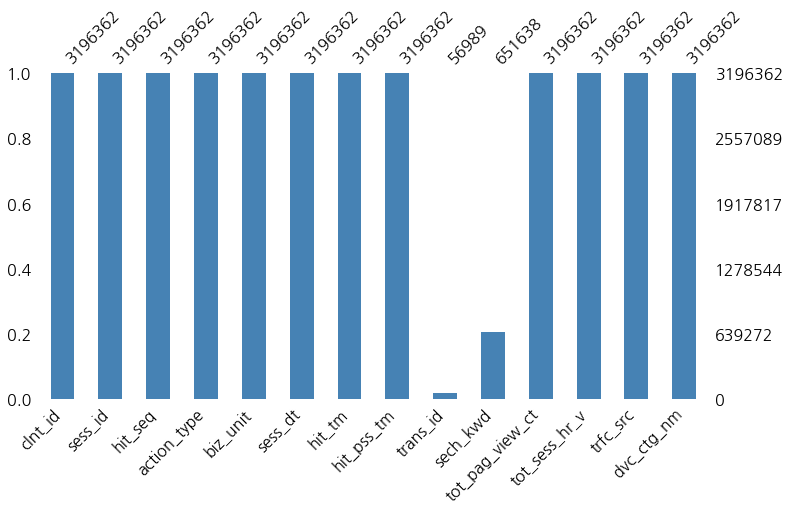

In [13]:
msno.bar(online, figsize=(12,6), color='steelblue')

## 데이터 합치기

간단한 분석을 위해서 필요한 칼럼만 추출하고 merge하겠습니다.  
이때 4개의 데이터를 합쳐서 한개의 데이터로 만들어줍니다. 

In [21]:
online_col = ['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'hit_pss_tm', 'trans_id', 'sech_kwd', 'tot_pag_view_ct', 'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm']
trade_col = ['trans_id', 'biz_unit', 'pd_c', 'de_dt','de_tm', 'buy_am', 'buy_ct']
customer_col = ['clnt_id', 'clnt_gender', 'clnt_age']
item_col = ['pd_c', 'clac_nm3']

In [22]:
temp = pd.merge(online[online_col], trade[trade_col], on='trans_id')
temp = pd.merge(temp, customer[customer_col], on='clnt_id')
df_data = pd.merge(temp, item[item_col], on='pd_c')

df_data= df_data.drop(['sess_id', 'trans_id', 'biz_unit', 'pd_c' , 'hit_seq', 'de_tm'], axis = 1)
df_data.head()

,clnt_id,action_type,hit_pss_tm,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,de_dt,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm3
0,2,6,791905,NaN,61.0,911.0,DIRECT,unknown,20190729,36000,20,F,30.0,커피 음료를
1,2,6,3251794,NaN,85.0,3256.0,DIRECT,unknown,20190731,1800,1,F,30.0,커피 음료를
2,2,6,306944,NaN,23.0,353.0,DIRECT,unknown,20190801,9000,5,F,30.0,커피 음료를
3,202,6,3133410,NaN,73.0,3174.0,DIRECT,unknown,20190818,1000,1,M,40.0,커피 음료를
4,202,6,1015069,NaN,37.0,1029.0,DIRECT,unknown,20190914,900,1,M,40.0,커피 음료를


In [23]:
df_data['clnt_id'] = df_data['clnt_id'].dropna()

## 데이터 저장

In [24]:
df_data = df_data.sort_values(['de_dt'])
df_data.to_csv('./new_data/all_data_nm3.csv',index=False)